<a href="https://colab.research.google.com/github/dustoff06/Example/blob/main/For_Hameem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text Classification and Model Evaluation**

In [2]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import string
import spacy
import nltk
import re

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from nltk.stem import WordNetLemmatizer
from collections import Counter
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, auc, roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline

# Set plot style
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')

# Load data (update with correct file path)
df = pd.read_csv('/content/overview-of-recordings.csv')
df.head()


,audio_clipping,audio_clipping:confidence,background_noise_audible,background_noise_audible:confidence,overall_quality_of_the_audio,quiet_speaker,quiet_speaker:confidence,speaker_id,file_download,file_name,phrase,prompt,writer_id
0,no_clipping,1.0000,light_noise,1.0000,3.33,audible_speaker,1.0,43453425,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43453425_58166571.wav,When I remember her I feel down,Emotional pain,21665495
1,light_clipping,0.6803,no_noise,0.6803,3.33,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_43347848.wav,When I carry heavy things I feel like breaking...,Hair falling out,44088126
2,no_clipping,1.0000,no_noise,0.6655,3.33,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_53187202.wav,there is too much pain when i move my arm,Heart hurts,44292353
3,no_clipping,1.0000,light_noise,1.0000,3.33,audible_speaker,1.0,31349958,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_31349958_55816195.wav,My son had his lip pierced and it is swollen a...,Infected wound,43755034
4,no_clipping,1.0000,no_noise,1.0000,4.67,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_82524191.wav,My muscles in my lower back are aching,Infected wound,21665495


# **Exploratory Data Analysis**

In [3]:

# Function to explore data
def explore_data(df):
    print(f"The data contains {df.shape[0]} rows and {df.shape[1]} columns.")
    print('Dataset columns:', df.columns)
    print(df.info())

explore_data(df)


The data contains 6661 rows and 13 columns.
Dataset columns: Index(['audio_clipping', 'audio_clipping:confidence',
       'background_noise_audible', 'background_noise_audible:confidence',
       'overall_quality_of_the_audio', 'quiet_speaker',
       'quiet_speaker:confidence', 'speaker_id', 'file_download', 'file_name',
       'phrase', 'prompt', 'writer_id'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6661 entries, 0 to 6660
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   audio_clipping                       6661 non-null   object 
 1   audio_clipping:confidence            6661 non-null   float64
 2   background_noise_audible             6661 non-null   object 
 3   background_noise_audible:confidence  6661 non-null   float64
 4   overall_quality_of_the_audio         6661 non-null   float64
 5   quiet_speaker                        66

# **Text Preprocessing**

In [4]:

# Text preprocessing
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

df_text = df[['phrase', 'prompt']]
df_text['phrase_length'] = df_text['phrase'].apply(len)
df_text['phrase_num_words'] = df_text['phrase'].apply(lambda x: len(x.split()))
df_text['mean_word_len'] = df_text['phrase'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_text['phrase_non_stopwords'] = df_text['phrase'].apply(lambda x: len([t for t in x.split() if t not in STOP_WORDS]))

# Text cleaning function
def clean_txt(docs):
    lemmatizer = WordNetLemmatizer()
    speech_words = nltk.word_tokenize(docs)
    lower_text = [w.lower() for w in speech_words]
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    stripped = [re_punc.sub('', w) for w in lower_text]
    words = [word for word in stripped if word.isalpha()]
    words = [w for w in words if w not in STOP_WORDS]
    words = [word for word in words if len(word) > 2]
    lem_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lem_words)

df_text['cleaned_phrase'] = df_text['phrase'].apply(clean_txt)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Model Spot-Checking**

In [5]:
# Model setup with NO vectorizers in the pipeline
def NormalizedTextModel(nameOfvect):
    pipelines = []
    pipelines.append((nameOfvect + 'MultinomialNB', MultinomialNB()))  # No Pipeline wrapping needed
    pipelines.append((nameOfvect + 'CCCV', CalibratedClassifierCV()))
    pipelines.append((nameOfvect + 'KNN', KNeighborsClassifier()))
    # Add more models as necessary
    return pipelines




# **Model Training and Evaluation**

In [6]:
# Model training function with error handling
def fit_model(X_train, y_train, models):
    num_folds = 10
    scoring = 'accuracy'

    for name, model in models:
        try:
            print(f"Training model: {name}")
            kfold = KFold(n_splits=num_folds)
            cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
            print(f"{name}: {cv_results.mean():.2f} ({cv_results.std():.2f})")
        except Exception as e:
            print(f"Error occurred while training {name}: {e}")


# **Train-Test Split and Naive Bayes Model**

In [7]:

# Train-test split
def read_in_and_split_data(data, features, target):
    X = data[features]
    y = data[target]
    return train_test_split(X, y, test_size=0.2, random_state=0)

# Naive Bayes model
def naive_bayes_classifier(X_train, X_test, y_train, y_test):
    model = MultinomialNB()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Naive Bayes Accuracy: {accuracy * 100:.2f}%")
    return predictions


# **Vectorizing Text Data**

In [8]:
# Vectorization step remains unchanged
def vectorize_text_data(train_data, test_data):
    vectorizer = TfidfVectorizer(max_features=1000)
    X_train_tfidf = vectorizer.fit_transform(train_data)
    X_test_tfidf = vectorizer.transform(test_data)

    print("Vectorized training data shape:", X_train_tfidf.shape)
    print("Vectorized test data shape:", X_test_tfidf.shape)

    return X_train_tfidf, X_test_tfidf

# Prepare data for model training
X = 'cleaned_phrase'
target_class = 'prompt'

# Split the data
X_train_raw, X_test_raw, y_train, y_test = read_in_and_split_data(df_text, X, target_class)

# Vectorize the text data
X_train, X_test = vectorize_text_data(X_train_raw, X_test_raw)

# Ensure y_train and y_test are numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Define models (no vectorization in the models)
models = NormalizedTextModel('tfvect')

# Model training function (simplified with no Pipelines)
def fit_model(X_train, y_train, models):
    num_folds = 10
    scoring = 'accuracy'

    for name, model in models:
        try:
            print(f"Training model: {name}")
            kfold = KFold(n_splits=num_folds)
            cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
            print(f"{name}: {cv_results.mean():.2f} ({cv_results.std():.2f})")
        except Exception as e:
            print(f"Error occurred while training {name}: {e}")

# Train the models
fit_model(X_train, y_train, models)


Vectorized training data shape: (5328, 891)
Vectorized test data shape: (1333, 891)
Training model: tfvectMultinomialNB
tfvectMultinomialNB: 0.97 (0.01)
Training model: tfvectCCCV
tfvectCCCV: 0.99 (0.00)
Training model: tfvectKNN
tfvectKNN: 0.99 (0.00)


# **Plot Confusion Plot for Naive Bayes**

Naive Bayes Accuracy: 97.15%


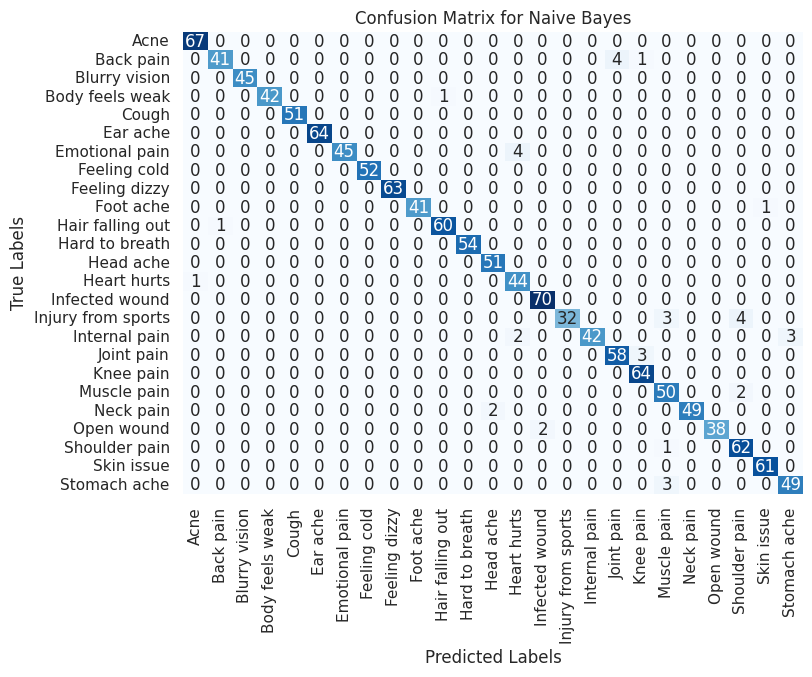

In [10]:

# ROC Curve plotting
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_test, y_pred, model_name):
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plotting the confusion matrix using seaborn's heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))

    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


# Use Naive Bayes classifier
naive_bayes_predictions = naive_bayes_classifier(X_train, X_test, y_train, y_test)

# Plot ROC curve for Naive Bayes
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train, y_train)
nb_probs = naive_bayes_model.predict_proba(X_test)[:, 1]
y_pred = naive_bayes_model.predict(X_test)

# Plot confusion matrix using predicted class labels
plot_confusion_matrix(y_test, y_pred, 'Naive Bayes')
